# Solving the heat equation using isogeometric analysis in G+Smo
**Author**: Felix Scholz, felix.scholz@jku.at

In this notebook we first introduce an isogeometric time stepping formulation for solving the heat equation. Afterwards, we demonstrate how to implement this scheme using the Python bindings of the [G+Smo library](https://github.com/gismo/gismo).

## An isogeometric time-stepping scheme for the heat equation

In this notebook, we solve the heat equation
\begin{align*}
\frac{\partial u}{\partial t} - \Delta u &= 0 &&\text{in } \Omega\times[0,T],\\
u &= g_D &&\text{on } \Gamma_D\times[0,T],\\
\frac{\partial u}{\partial\mathbf n} &= g_N &&\text{on } \Gamma_N\times[0,T],\\
u &= u_0 &&\text{on } \Omega\times\{0\},
\end{align*}
on a computational domain $\Omega$, where $\Gamma_D \cup \Gamma_N = \partial\Omega$ are the Dirichlet and Neumann boundaries, $g_D: \Gamma_D\times [0,T] \rightarrow \mathbb R$ is the Dirichlet boundary condition, $g_N: \Gamma_N\times [0,T] \rightarrow \mathbb R$ is the Neumann boundary condition and $\mathbf n$ is the outward-pointing normal at $\Gamma$.

### Time discretization

Since we plan to use a time-stepping scheme, we choose a time step $\Delta t > 0$ and define time slices 
$$
0=t_0\ldots t_N\leq T 
$$
with  $t_i = i\Delta i$.
In particular, we use the Crank-Nicolson scheme to discretize the time derivative, i.e.
$$
\frac{u^{i+1} - u^{i}}{\Delta t} - \frac12\Delta u^{i+1} - \frac12\Delta u^i = 0.
$$

### Spatial discretization
We multiply with a test function $v$ with $\left.v\right|_{\Gamma_D}=0$ and integrate, obtaining
$$
\int_{\Omega} \frac{u^{i+1} - u^{i}}{\Delta t} v \mathrm d x - \frac12\int_{\Omega}\Delta u^{i+1}v\mathrm d x - \frac12\int_{\Omega}\Delta u^{i}v\mathrm d x = 0
$$
and by integration by parts
$$
\int_{\Omega}u^{i+1}v\mathrm d x + \frac{\Delta t}2\int_{\Omega}\nabla u^{i+1}\cdot\nabla v\mathrm d x = \int_{\Omega}u^{i}v\mathrm d x -\frac{\Delta t}2\int_{\Omega}\nabla u^{i}\cdot\nabla v\mathrm d x + \frac{\Delta t}2\int_{\Gamma_N}v\left.g_N\right|_{t=t_{i+1}}\mathrm d\Gamma + \frac{\Delta t}2\int_{\Gamma_N}v\left.g_N\right|_{t=t_i}\mathrm d\Gamma,
$$
where we  multiplied the equation by $\Delta t$ and inserted the Neumann boundary conditions for $\frac{\partial u}{\partial\mathbf n}$.

### Isogeometric discretization

In isogeometric analysis, we search for the solution $u$ in the isogeometric function space $V_h$, which is spanned by
$$
B_{i} = \hat B_{i}\circ G^{-1},
$$
where $\hat B_{i}$ are the tensor-product B-spline basis functions, defined over the parameter domain $[0,1]^2$, and $G: [0,1]^2\rightarrow \Omega$ is the geometry mapping.

By assuming $u = \sum_iu_iB_i$ and $v = \sum_iv_iB_i$ to be isogeometric functions, we obtain the discrete formulation
$$
\left(S + \frac{\Delta t}2 M \right)u^{i+1} = \left(M - \frac{\Delta t}2 S\right) u^i + \frac{\Delta t}2 f^{i+1} + \frac{\Delta t}2 f^{i},
$$
where
$$
S_{ij} = \int_{\Omega}\nabla B_i\cdot \nabla B_j\mathrm d x = \int_{[0,1]^2}\nabla_\xi \hat B_i\cdot J_G^{-1}J_G^{-T} \nabla_\xi \hat B_j |\det(J_G)| \mathrm d \xi
$$
is the stiffness matrix,
$$
M_{ij} = \int_{\Omega}B_i\cdot B_j\mathrm d x = \int_{[0,1]^2}\hat B_i\cdot\hat B_j\mathrm |\det(J_G)|d\xi
$$
is the mass matrix, and
$$
f_j^{i} = \int_{\Gamma_N}\left.g_N\right|_{t=t_i} B_j\mathrm d\Gamma
$$
corresponds to the Neumann boundary conditions.

### Geometry, boundary conditions and initial conditions
In the remainder of this notebook, we will consider the heat equation with
\begin{align*}
\Omega &= [0, 1]^2 \\
g_D &\equiv 0\\
g_N &\equiv -1\\
u_0 &\equiv 0\\
\Gamma_N &= \{0\}\times [0,1]\\
\Gamma_D &= \partial \Omega\setminus\Gamma_N
\end{align*}
This means that the initial temperature is zero everywhere, three boundary edges of the unit square are permanently cooled down to zero and there is a constant inflow of heat along the remaining boundary edge.

## Implementation of the scheme using G+Smo

### Initial definitions and imports
We import the `gismo` namespace from `gismo_cppyy`. It contains all definitions of the G+Smo library.

In [1]:
from gismo_cppyy import gismo

We want to use matplotlib for plotting the result of our simulation, so we define a function that plots the solution as a color plot over the unit square:

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import copy

def plotfield(field, evaluator, time, ax, n=100):
    evalpoints=evalgrid(field, evaluator, n=n)

    ax.set_title(f"Time: {time}s", loc="left")
    ax.imshow(evalpoints.reshape(n, n), interpolation="bilinear", cmap="coolwarm", vmin=0.0, vmax=.5, extent=[0., 1., 0., 1.])

def evalgrid(field, evaluator, n=100):
    corners = gismo.gsMatrix["real_t"].fromnumpy(np.array([[0., 1.], [0.,1.]]))
    numpoints = gismo.gsVector["int"](2)
    numpoints[0] = n
    numpoints[1] = n
    gismogrid = gismo.gsGridIterator["double", gismo.CUBE, 2](corners, numpoints)

    evaluator.eval(field, gismogrid, 0)
    evalpoints = gismo.gsVector["real_t"](evaluator.allValues()).tonumpy()

    return copy.deepcopy(evalpoints.reshape(n,n))

Note that we have used here the functions `tonumpy()` and `fromnumpy()` in order to convert between G+Smo matrices and numpy arrays.

### Defining the domain and the boundary conditions

Our computational domain $\Omega$ is the unit square, parameterized by the identity $G:[0,1]^2\rightarrow \Omega$. We already set the degree of the B-spline representation to 2, since we want to approximate the solution $u^i$ at each time step with a biquadratic tensor product B-spline function.

In [3]:
multipatch = gismo.gsMultiPatch["real_t"](gismo.gsNurbsCreator["real_t"].BSplineSquareDeg(2))

print("Geometry:")
print(multipatch)
for i, patch in enumerate(multipatch):
    print(f"Patch no. {i}:\n{patch}")

Geometry:
gsMultiPatch (1): #Boundaries= 4, #Interfaces= 0.

Patch no. 0:
Tensor BSpline geometry R^2 --> R^2, #control pnts= 9: 0 0 ... 1 1
Basis:
TensorBSplineBasis: dim=2, size=9.
  Direction 0: [ 0 0 0 1 1 1 ] (deg=2, size=6, minSpan=1, maxSpan=1) 
  Direction 1: [ 0 0 0 1 1 1 ] (deg=2, size=6, minSpan=1, maxSpan=1) 



As boundary conditions, we set homogeneous Dirichlet conditions on three sides and a constant negative Neumann boundary condition on the remaining side.

In [4]:
boundarycondition = gismo.gsBoundaryConditions["real_t"]()
neumanncond = gismo.gsFunctionExpr["real_t"] ("-1", 2)
dirichletcond = gismo.gsFunctionExpr["real_t"] ("0", 2)

boundarycondition.addCondition(0, gismo.boundary.west, gismo.condition_type.neumann, neumanncond)
boundarycondition.addCondition(0, gismo.boundary.east, gismo.condition_type.dirichlet, dirichletcond)
boundarycondition.addCondition(0, gismo.boundary.north, gismo.condition_type.dirichlet, dirichletcond)
boundarycondition.addCondition(0, gismo.boundary.south, gismo.condition_type.dirichlet, dirichletcond)
boundarycondition.setGeoMap(multipatch)

print(f"Number of boundary segments: \n{boundarycondition}\n"
        f"Dirichlet boundary condition: {dirichletcond}\n"
        f"Neumann boundary condition: {neumanncond}")

Number of boundary segments: 
* Dirichlet     : 3
* Neumann       : 1

Dirichlet boundary condition: [ 0 ]
Neumann boundary condition: [ -1 ]


### Discretizing the spatial derivatives
As described in the first Section, we will use a Galerkin method to discretize the derivatives in space and a finite difference method to discretize the time derivative.


#### Basis for the isogeometric function space

For each time step $t_i$ , we will find the solution $u_i^i$ in an isogeometric function space $V_h$ based on uniform biquadratic tensor product B-splines.
We take the biquadratic tensor product B-spline basis that was used to represent the geometry and we refine it a couple of times to increase the accuracy of our simulation.

In [5]:
basis = gismo.gsMultiBasis["real_t"](multipatch, True)

for _ in range(5):
        basis.uniformRefine()

print(f"Basis used for approxmating the solution:\n\n{basis.basis(0)}")

Basis used for approxmating the solution:

TensorBSplineBasis: dim=2, size=1156.
  Direction 0: [ 0 0 0 0.03125 0.0625 ... 0.9375 0.96875 1 1 1 ] (deg=2, size=37, minSpan=0.03125, maxSpan=0.03125) 
  Direction 1: [ 0 0 0 0.03125 0.0625 ... 0.9375 0.96875 1 1 1 ] (deg=2, size=37, minSpan=0.03125, maxSpan=0.03125) 



#### Assembly of the mass matrix
We need the mass matrix
$$
M_{ij} = \int_{[0,1]^2}\hat B_i\cdot\hat B_j\mathrm |\det(J_G)|d\xi
$$
in our time stepping scheme, so we assemble it using G+Smo's expression assembler.

In [6]:
A_mass = gismo.gsExprAssembler["real_t"]()
A_mass.setIntegrationElements(basis)

G_mass = A_mass.getMap(multipatch)
u_mass = A_mass.getSpace(basis)

u_mass.setup(boundarycondition, gismo.dirichlet.l2Projection, 0)
A_mass.initSystem()

A_mass.assemble(u_mass*u_mass.tr() * gismo.expr.meas(G_mass))

massMatrix = A_mass.matrix()

The expression assembler `A_mass` assembles a bilinear form based on an *expression*. In this case, we use `u_mass*u_mass.tr() * gismo.expr.meas(G_mass)` to assemble the mass matrix. Here, `u_mass` refers to the discrete function space and `G_mass` represents the geometry mapping. `meas(G_mass)` is the Jacobian determant.

#### Assembly of the stiffness matrix and the source vector

Next, we assemble the stiffness matrix 
$$
S_{ij} = \int_{[0,1]^2}\nabla_\xi \hat B_i\cdot J_G^{-1}J_G^{-T} \nabla_\xi \hat B_j |\det(J_G)| \mathrm d \xi
$$
and the vector 
$$
f_j = \int_{\Gamma_N}g_N B_j\mathrm d\Gamma
$$
containing the Neumann boundary condition. Since we assumed $g_N$ to be constant in time, we only need to assemble $f$ once.

In [7]:
A_stiff = gismo.gsExprAssembler["real_t"]()
A_stiff.setIntegrationElements(basis)

G_stiff = A_stiff.getMap(multipatch)
u_stiff = A_stiff.getSpace(basis)
g_N_stiff = A_stiff.getBdrFunction(G_stiff)

u_stiff.setup(boundarycondition, gismo.dirichlet.l2Projection, 0)
A_stiff.initSystem()

A_stiff.assemble(gismo.expr.igrad(u_stiff, G_stiff) * gismo.expr.igrad(u_stiff, G_stiff).tr() * gismo.expr.meas(G_stiff))
A_stiff.assembleBdr(boundarycondition.get("Neumann"), u_stiff * g_N_stiff.tr() * gismo.expr.nv(G_stiff))

stiffnessmatrix = A_stiff.matrix()
rhs = A_stiff.rhs()

`G_stiff` is an expression representing the geometry mapping, `u_stiff` is an expression representing the discrete function space and `g_N_stiff` is the boundary function. `meas(G_stiff)` refers to the norm of the Jacobian determinant of the geometry mapping and `nv` is the outward pointing normal.


The expression assembler `A_stiff` assembles the bilinear form and the linear form based based on the expressions.
Here, `igrad(u_stiff, G_stiff)` is short for `grad(u) * jac(G).inv()`. Therefore, the assembled bilinear form  is indeed the stiffness matrix.
The assembler also imposes the strong boundary conditions.

### Solver and initial condition
We will use the LU solver to compute the time steps.

In [8]:
solver = gismo.gsSparseSolver["real_t"].LU()

We set the initial temperature distribution $u_0$ to be constant 0.

Let's now plot the initial condition. We create an expression evaluator and an expression for the initial solution and we use the `plotfield` function that we defined above. 


/home/minsky/felix/Programs/gismo/venv/lib/python3.11/site-packages/matplotlib/image.py:500: RuntimeWarning: overflow encountered in divide
  vrange /= ((a_max - a_min) / frac)


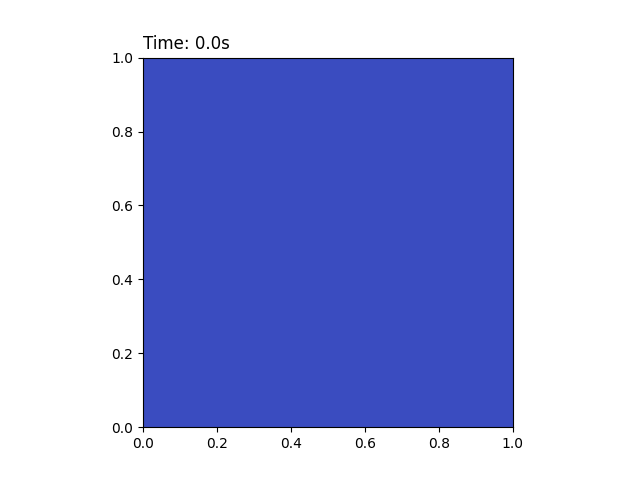

In [9]:
solvector = gismo.gsMatrix["real_t"]()
solvector.setZero(A_stiff.numDofs(), 1);

ev = gismo.gsExprEvaluator["real_t"](A_stiff)
u_sol = A_stiff.getSolution(u_stiff, solvector)


fig = plt.figure()
ax = fig.add_subplot(111)

plotfield(field=u_sol, evaluator=ev, time=0.0, ax=ax)

plt.show()

As expected, the temperature is zero everywhere. We will now change this by running our simulation.

### Performing the time stepping
We can now start our time-stepping scheme. We set the end time $T$ as well as the time step $\Delta t$.

Luckily, we only need to compute factorization of the system matrix 
$$
M + \frac{\Delta t}2S
$$
once.

In [10]:
endTime = 0.4
numSteps = 100
Dt = endTime / (numSteps - 1)

solver.compute(massMatrix + stiffnessmatrix * Dt * 0.5);

We will now iterate over the time steps until we reach the final time. In each step, we update the current solution to be the solution of the linear system
$$
\left(M + \frac{\Delta t}2S\right) u^{i+1} = \Delta tf + \left(M - \frac{\Delta t}2S\right)u^i.
$$
We then use our plot function to visualize the solution at the current time step.

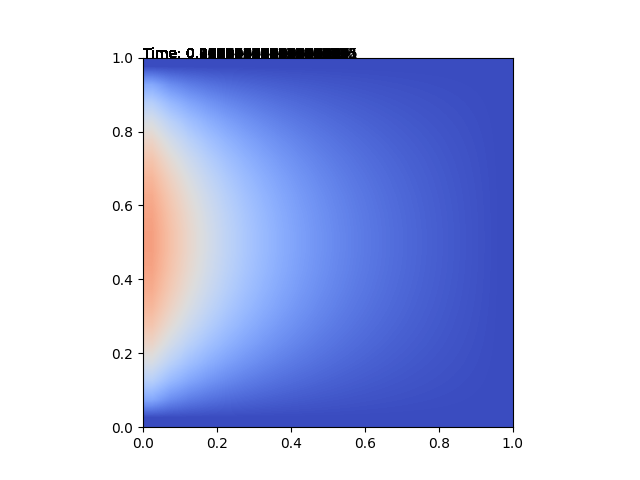

In [11]:
import matplotlib.animation as animation
import time

img_array = []

fig1 = plt.figure()
ax = fig1.add_subplot(111)

# Set initial condition back to zero in case that we run the cell multiple times
solvector = gismo.gsMatrix["real_t"]()
solvector.setZero(A_stiff.numDofs(), 1);

for step in range(numSteps):
    # Solve for the next time step
    solvector = solver.solve(rhs * Dt + (massMatrix - stiffnessmatrix * Dt* 0.5) * solvector)
    # Get solution
    u_sol = A_stiff.getSolution(u_stiff, solvector)

    # Create image of the current time step
    img = ax.imshow(evalgrid(field=u_sol, evaluator=ev,n=20),
                     interpolation="bilinear", cmap="coolwarm", vmin=0.0, vmax=.5, extent=[0., 1., 0., 1.], animated=True)
    t = ax.annotate(f"Time: {step*Dt}",(0,1))
    
    img_array.append([img, t])

# Generate the animation
ani = animation.ArtistAnimation(fig1, img_array, interval=200, repeat=True, repeat_delay=2000)
time.sleep(0.1)
plt.show()